In [124]:
import matplotlib.pyplot as plt
from math import ceil
import math
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# using statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix
import pylab as py

### Import

In [38]:
loan_df = pd.read_csv('../data/intrest_rates.csv')

### Initial EDA

In [39]:
loan_df.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length
0,8.90,735-739,20000,20000.0,36
1,12.12,715-719,19200,19200.0,36
2,21.98,690-694,35000,35000.0,60
3,9.99,695-699,10000,9975.0,36
4,11.71,695-699,12000,12000.0,36


In [40]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   interest_rate               2498 non-null   float64
 1   fico_range                  2498 non-null   object 
 2   amount_requested            2498 non-null   int64  
 3   amount_funded_by_investors  2498 non-null   float64
 4   loan_length                 2498 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 97.7+ KB


In [41]:
loan_df.describe()

,interest_rate,amount_requested,amount_funded_by_investors,loan_length
count,2498.000000,2498.000000,2498.000000,2498.000000
mean,13.070368,12413.030424,12009.280661,41.265012
std,4.178007,7801.222483,7743.387861,9.933753
min,5.420000,1000.000000,-0.010000,36.000000
25%,10.160000,6000.000000,6000.000000,36.000000
50%,13.110000,10000.000000,10000.000000,36.000000
75%,15.800000,17000.000000,16000.000000,36.000000
max,24.890000,35000.000000,35000.000000,60.000000


In [42]:
loan_df['fico_range']

0       735-739
1       715-719
2       690-694
3       695-699
4       695-699
         ...   
2493    705-709
2494    740-744
2495    680-684
2496    675-679
2497    670-674
Name: fico_range, Length: 2498, dtype: object

In [43]:
fico = loan_df['fico_range'].str.findall('(\d+)')
fico

0       [735, 739]
1       [715, 719]
2       [690, 694]
3       [695, 699]
4       [695, 699]
           ...    
2493    [705, 709]
2494    [740, 744]
2495    [680, 684]
2496    [675, 679]
2497    [670, 674]
Name: fico_range, Length: 2498, dtype: object

In [44]:
fico_means = pd.Series([])
for i in range (0,len(fico)):
    fico[i] = np.array(fico[i]).astype(np.float64)
    fico_means[i] = sum(fico[i])/len(fico[i])
fico_means

C:\Users\benha\AppData\Local\Temp\ipykernel_45992\1568151351.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  fico_means = pd.Series([])


0       737.0
1       717.0
2       692.0
3       697.0
4       697.0
        ...  
2493    707.0
2494    742.0
2495    682.0
2496    677.0
2497    672.0
Length: 2498, dtype: float64

In [45]:
loan_df['fico_score'] = fico_means
loan_df

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_score
0,8.90,735-739,20000,20000.00,36,737.0
1,12.12,715-719,19200,19200.00,36,717.0
2,21.98,690-694,35000,35000.00,60,692.0
3,9.99,695-699,10000,9975.00,36,697.0
4,11.71,695-699,12000,12000.00,36,697.0
...,...,...,...,...,...,...
2493,16.77,705-709,30000,29950.00,60,707.0
2494,14.09,740-744,16000,16000.00,60,742.0
2495,13.99,680-684,10000,10000.00,36,682.0
2496,12.42,675-679,6000,6000.00,36,677.0


In [46]:
loan_df.replace({36:0,60:1},inplace=True)

In [53]:
# loan_df[loan_df['amount_funded_by_investors']<0]

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_score


In [52]:
loan_df.replace({-0.01:0},inplace=True)

In [54]:
loan_df.describe()

,interest_rate,amount_requested,amount_funded_by_investors,loan_length,fico_score
count,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000
mean,13.070368,12413.030424,12009.280669,0.219376,707.858687
std,4.178007,7801.222483,7743.387848,0.413906,34.994039
min,5.420000,1000.000000,0.000000,0.000000,642.000000
25%,10.160000,6000.000000,6000.000000,0.000000,682.000000
50%,13.110000,10000.000000,10000.000000,0.000000,702.000000
75%,15.800000,17000.000000,16000.000000,0.000000,727.000000
max,24.890000,35000.000000,35000.000000,1.000000,832.000000


#### Loan Length; 0 equals 36 month term, 1 equals 60 month term

In [48]:
loan_df

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_score
0,8.90,735-739,20000,20000.00,0,737.0
1,12.12,715-719,19200,19200.00,0,717.0
2,21.98,690-694,35000,35000.00,1,692.0
3,9.99,695-699,10000,9975.00,0,697.0
4,11.71,695-699,12000,12000.00,0,697.0
...,...,...,...,...,...,...
2493,16.77,705-709,30000,29950.00,1,707.0
2494,14.09,740-744,16000,16000.00,1,742.0
2495,13.99,680-684,10000,10000.00,0,682.0
2496,12.42,675-679,6000,6000.00,0,677.0


array([[<Axes: xlabel='interest_rate', ylabel='interest_rate'>,
        <Axes: xlabel='amount_requested', ylabel='interest_rate'>,
        <Axes: xlabel='amount_funded_by_investors', ylabel='interest_rate'>,
        <Axes: xlabel='loan_length', ylabel='interest_rate'>,
        <Axes: xlabel='fico_score', ylabel='interest_rate'>,
        <Axes: xlabel='funding_difference', ylabel='interest_rate'>],
       [<Axes: xlabel='interest_rate', ylabel='amount_requested'>,
        <Axes: xlabel='amount_requested', ylabel='amount_requested'>,
        <Axes: xlabel='amount_funded_by_investors', ylabel='amount_requested'>,
        <Axes: xlabel='loan_length', ylabel='amount_requested'>,
        <Axes: xlabel='fico_score', ylabel='amount_requested'>,
        <Axes: xlabel='funding_difference', ylabel='amount_requested'>],
       [<Axes: xlabel='interest_rate', ylabel='amount_funded_by_investors'>,
        <Axes: xlabel='amount_requested', ylabel='amount_funded_by_investors'>,
        <Axes: xlabel='

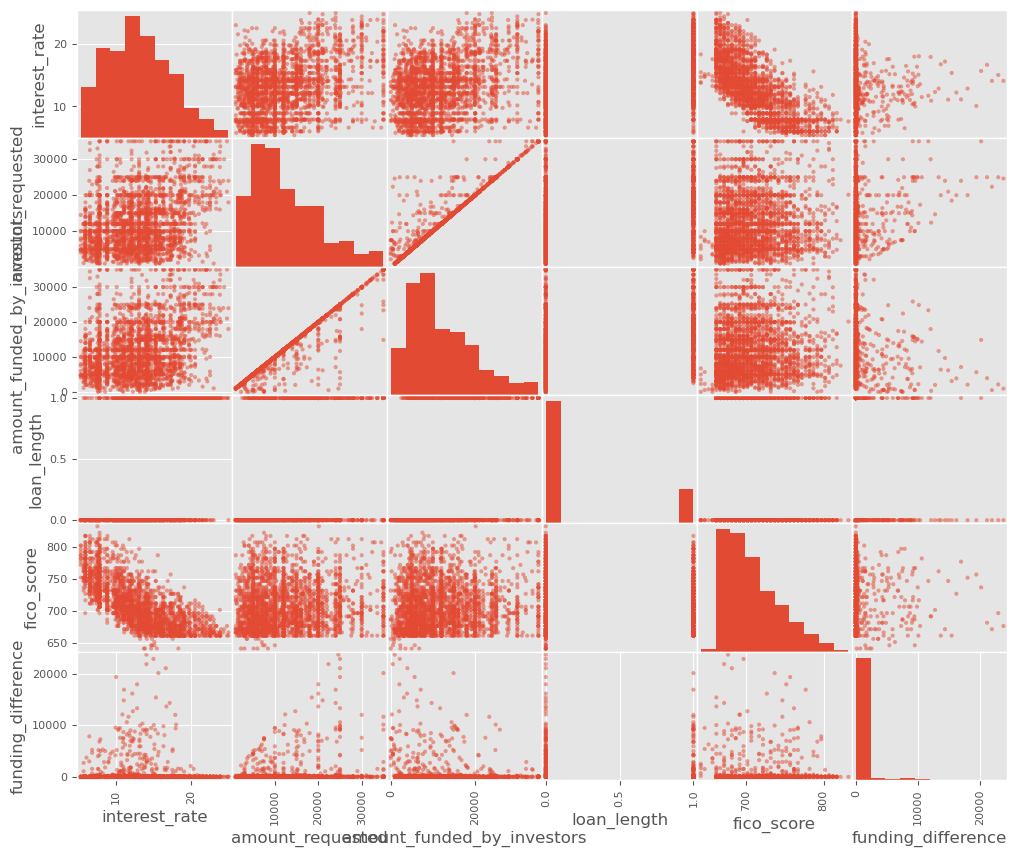

In [116]:
scatter_matrix(loan_df,figsize=(12,10))

In [50]:
loan_df.corr()

C:\Users\benha\AppData\Local\Temp\ipykernel_45992\804777513.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_df.corr()


,interest_rate,amount_requested,amount_funded_by_investors,loan_length,fico_score
interest_rate,1.000000,0.331831,0.336830,0.423506,-0.709216
amount_requested,0.331831,1.000000,0.969841,0.412298,0.083378
amount_funded_by_investors,0.336830,0.969841,1.000000,0.406218,0.074284
loan_length,0.423506,0.412298,0.406218,1.000000,0.012703
fico_score,-0.709216,0.083378,0.074284,0.012703,1.000000


In [88]:
loan_df['funding_difference'] =  loan_df['amount_requested']- loan_df['amount_funded_by_investors']
loan_df

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_score,funding_difference
0,8.90,735-739,20000,20000.00,0,737.0,0.00
1,12.12,715-719,19200,19200.00,0,717.0,0.00
2,21.98,690-694,35000,35000.00,1,692.0,0.00
3,9.99,695-699,10000,9975.00,0,697.0,25.00
4,11.71,695-699,12000,12000.00,0,697.0,0.00
...,...,...,...,...,...,...,...
2493,16.77,705-709,30000,29950.00,1,707.0,50.00
2494,14.09,740-744,16000,16000.00,1,742.0,0.00
2495,13.99,680-684,10000,10000.00,0,682.0,0.00
2496,12.42,675-679,6000,6000.00,0,677.0,0.00


### Initial Regression Analysis

In [123]:
X = loan_df[['amount_requested','funding_difference','loan_length','fico_score']]
# X = loan_df['amount_requested']
y = loan_df['interest_rate']

X = sm.add_constant(X)

simple_model = sm.OLS(y,X).fit()
simple_predictions = simple_model.predict(X)

print_simple_table = simple_model.summary()
print(print_simple_table)

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     1833.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:10:58   Log-Likelihood:                -5402.6
No. Observations:                2498   AIC:                         1.082e+04
Df Residuals:                    2493   BIC:                         1.084e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 72.6600      0

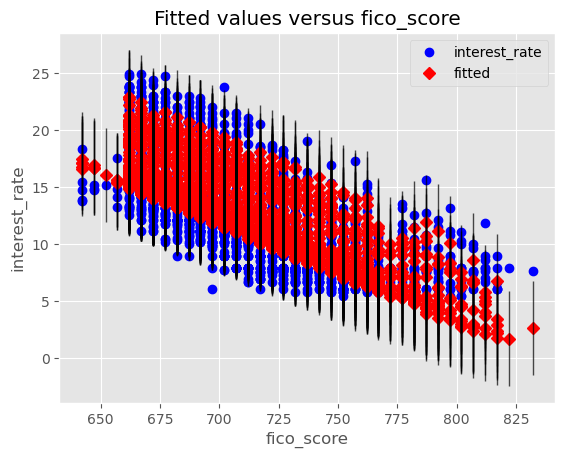

In [137]:
sm.graphics.plot_fit(simple_model,'fico_score');

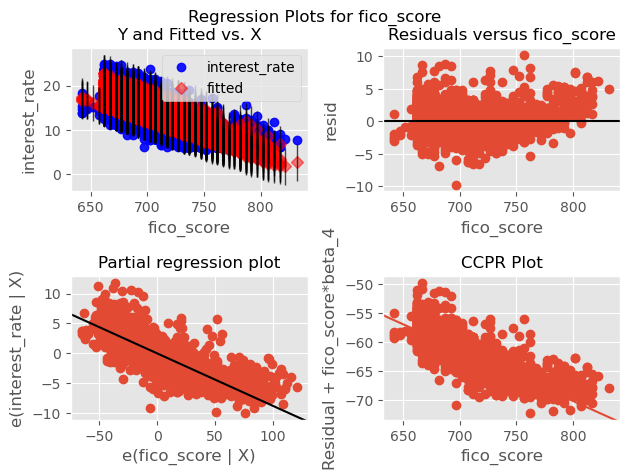

In [139]:
sm.graphics.plot_regress_exog(simple_model,'fico_score');

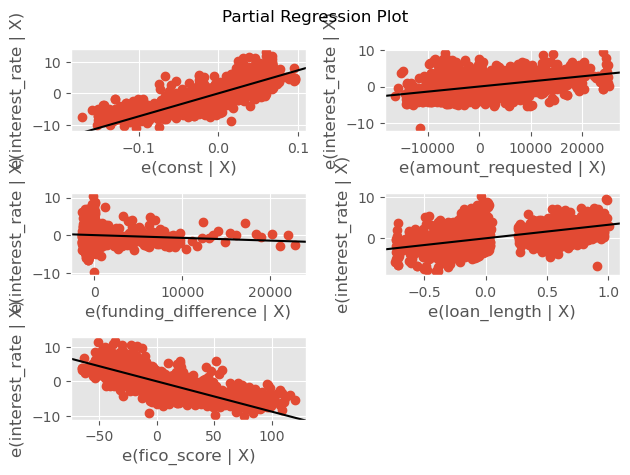

In [143]:
fig = sm.graphics.plot_partregress_grid(simple_model)
fig.tight_layout();

In [125]:
mean_squared_error(y,simple_predictions)

4.4268514918544355

In [60]:
loan_df['fico_score'].max()

832.0

In [67]:
loan_df['interest_rate'].max()

24.89

In [93]:
simple_predictions

0       10.841817
1       12.485894
2       20.160660
3       12.966572
4       13.243572
          ...    
2493    18.152002
2494    13.141968
2495    14.282729
2496    14.167449
2497    15.021668
Length: 2498, dtype: float64

In [97]:
loan_df['fico_score']
x = np.linspace(640,840,10)
pd.Series(x)

0    640.000000
1    662.222222
2    684.444444
3    706.666667
4    728.888889
5    751.111111
6    773.333333
7    795.555556
8    817.777778
9    840.000000
dtype: float64

In [114]:
x

array([640.        , 640.66889632, 641.33779264, 642.00668896,
       642.67558528, 643.34448161, 644.01337793, 644.68227425,
       645.35117057, 646.02006689, 646.68896321, 647.35785953,
       648.02675585, 648.69565217, 649.36454849, 650.03344482,
       650.70234114, 651.37123746, 652.04013378, 652.7090301 ,
       653.37792642, 654.04682274, 654.71571906, 655.38461538,
       656.05351171, 656.72240803, 657.39130435, 658.06020067,
       658.72909699, 659.39799331, 660.06688963, 660.73578595,
       661.40468227, 662.0735786 , 662.74247492, 663.41137124,
       664.08026756, 664.74916388, 665.4180602 , 666.08695652,
       666.75585284, 667.42474916, 668.09364548, 668.76254181,
       669.43143813, 670.10033445, 670.76923077, 671.43812709,
       672.10702341, 672.77591973, 673.44481605, 674.11371237,
       674.7826087 , 675.45150502, 676.12040134, 676.78929766,
       677.45819398, 678.1270903 , 678.79598662, 679.46488294,
       680.13377926, 680.80267559, 681.47157191, 682.14

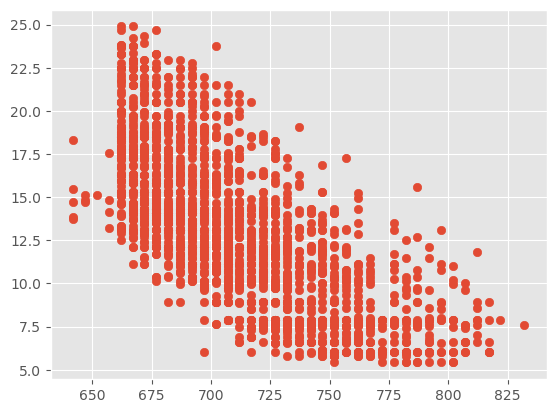

In [113]:
fig, ax = plt.subplots()

x = np.linspace(640,840,300)

ax.scatter(np.array(loan_df['fico_score']),y=np.array(y))


In [131]:
type(simple_predictions)

pandas.core.series.Series

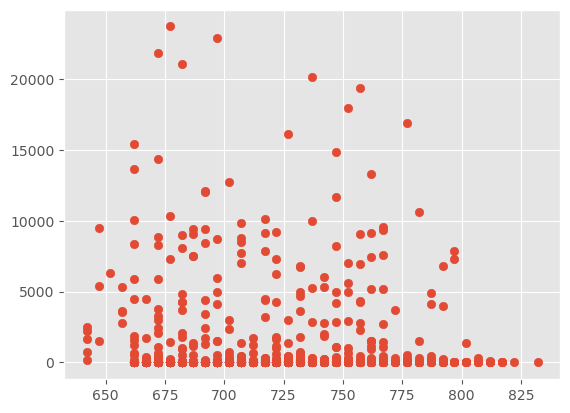

In [120]:
fig,ax = plt.subplots()

ax.scatter(loan_df['fico_score'],loan_df['funding_difference'])